# ML5 Mini Project - Learning Store Recommender

**The goal of this project is to leverage machine learning to make recommendations to Learning Store users.** 
Users are browsing anonymously the Learning Store. The recommender returns similar or related items as those they are being queried or viewed.
The recommender uses unsupervised machine learning to identify and group similarities in sets of data. 
Deliverable is a content filtering recommender returning items related to watched topic and a visualization of the cluster (inc. dimensionality reduction) and a cluster object locator !


## 1 - Import complete learning store database (6000+ Learning Objects)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib.pyplot import figure

import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the csv into a data frame
df = pd.read_csv("course_061120.csv")[['ID', 'Title', 'Description']]
df.head()

,ID,Title,Description
0,d.4,Emotional Intelligence,<p>Emotional intelligence is the skill at perc...
1,d.5,Stress Management & Balance,<p>This is a self-learning program for learnin...
2,d.6,Time Management & Productivity,<p>You'll learn strategies to better mangage y...
3,d.7,Public Speaking,"<p>In today’s business world, most of us need ..."
4,d.8,Virtual Team Communication,"<p><span style=""color: rgb(78, 78, 78);"">This ..."


## 2 - Return top 5 recommendation for a specific Learning Object (item) with confidence level > 0,3

In [3]:
print(df.columns)
print(df.shape)

Index(['ID', 'Title', 'Description'], dtype='object')
(6204, 3)


In [4]:
# Filter HTML tags
df['Description'] = df['Description'].apply(lambda text: BeautifulSoup(str(text)).get_text())

print(df.shape)
df.head()

(6204, 3)


,ID,Title,Description
0,d.4,Emotional Intelligence,Emotional intelligence is the skill at perceiv...
1,d.5,Stress Management & Balance,This is a self-learning program for learning s...
2,d.6,Time Management & Productivity,You'll learn strategies to better mangage your...
3,d.7,Public Speaking,"In today’s business world, most of us need to ..."
4,d.8,Virtual Team Communication,This curriculum addresses the challenges of wo...


In [5]:
df.isna().sum()

ID             0
Title          1
Description    0
dtype: int64

In [6]:
df = df[df['Description'].notna()]
df.shape

(6204, 3)

In [7]:
df.to_csv('sanitized.csv')
df.head()

,ID,Title,Description
0,d.4,Emotional Intelligence,Emotional intelligence is the skill at perceiv...
1,d.5,Stress Management & Balance,This is a self-learning program for learning s...
2,d.6,Time Management & Productivity,You'll learn strategies to better mangage your...
3,d.7,Public Speaking,"In today’s business world, most of us need to ..."
4,d.8,Virtual Team Communication,This curriculum addresses the challenges of wo...


In [8]:
# min_df=0.05, if words do not occur at least 5% they are ignored
vectorizer = TfidfVectorizer(stop_words='english')

X = vectorizer.fit_transform(df['Description'])
X_array = X.toarray()
X_array.shape

(6204, 14748)

In [9]:
sim_matrix = pd.DataFrame(cosine_similarity(X_array))
sim_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,6194,6195,6196,6197,6198,6199,6200,6201,6202,6203
0,1.000000,0.031842,0.012314,0.023379,0.000000,0.000000,0.164420,0.113540,0.000000,0.133426,...,0.088749,0.006601,0.005719,0.011361,0.020623,0.018315,0.003547,0.003259,0.0,0.000000
1,0.031842,1.000000,0.126755,0.062267,0.000000,0.000000,0.021218,0.064069,0.000000,0.079408,...,0.079753,0.000000,0.000000,0.000000,0.059081,0.000000,0.012529,0.029615,0.0,0.000000
2,0.012314,0.126755,1.000000,0.037286,0.045610,0.000000,0.008205,0.079291,0.056473,0.071120,...,0.030842,0.000000,0.000000,0.085003,0.153715,0.000000,0.009691,0.022905,0.0,0.000000
3,0.023379,0.062267,0.037286,1.000000,0.027016,0.082061,0.011799,0.040851,0.015915,0.041623,...,0.000000,0.015916,0.012097,0.000000,0.014887,0.000000,0.005462,0.005019,0.0,0.017897
4,0.000000,0.000000,0.045610,0.027016,1.000000,0.065550,0.000000,0.000000,0.021146,0.000000,...,0.000000,0.012423,0.000000,0.000000,0.000000,0.034469,0.014754,0.013558,0.0,0.000000


In [10]:
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

In [11]:
def recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6] # Get 5 most similar, exclude 0 as that'll be the input
    target_indices = [i[0] for i in sim_scores if i[1] > 0.3]
    return df.iloc[target_indices]

In [12]:
recommendations('Public Speaking')

,ID,Title,Description
5583,n.1602824846478,NSW AS&C KMCD Communications and Public Speaking,Here you find list of recommended learning mat...


## 3 - Group all Learning Object in Clusters

In [13]:
# Purely theoretical, see how the shape transforms from (6204, 13665) to (6204, 50). 
# PCA reduces the amount of components into (in this case) 50 components which represent a single dimensional view of the pre-existing components.
X_pca = PCA(n_components=50).fit_transform(X.toarray())
X_reduced = TSNE(n_components=2, learning_rate=400, perplexity=35).fit_transform(X_pca)
clusters = KMeans(n_clusters=35).fit_predict(X_reduced)
print('PCA', X_pca.shape)
print('TSNE', X_reduced.shape)

PCA (6204, 50)
TSNE (6204, 2)


## 4 - Plot all Learning Object per cluster

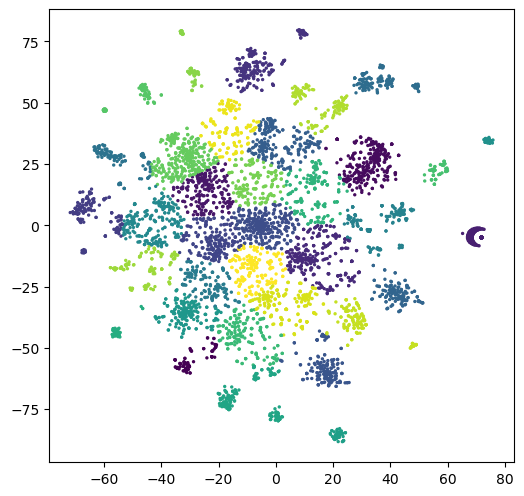

In [14]:
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=2)
plt.show()

## 5 - Create a Learning Object Locator
This function returns the graphical position of the learning Object plot in the galaxy of clusters

In [15]:
def locate_courses(title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))

    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=5)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=5)

    idx1 = indices[title1]
    coords1 = X_reduced[idx1]
    if isinstance(coords1, np.ndarray) and len(coords1) > 2:
        coords1 = coords1[0]

    ax1.axvline(x=coords1[0], color='r', linestyle='-')
    ax1.axhline(y=coords1[1], color='r', linestyle='-')

    idx2 = indices[title2]
    coords2 = X_reduced[idx2]
    if isinstance(coords2, np.ndarray) and len(coords2) > 2:
        coords2 = coords2[0]

    print(coords2)
    ax2.axvline(x=coords2[0], color='r', linestyle='-')
    ax2.axhline(y=coords2[1], color='r', linestyle='-')

    plt.show()

[-4.8726807 32.94005  ]


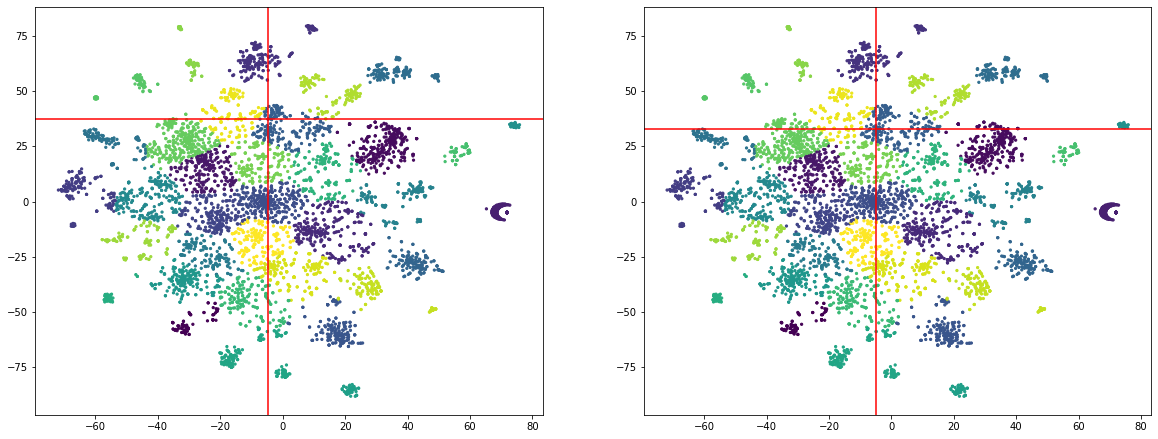

In [16]:
locate_courses('Emotional Intelligence', 'Stress Management & Balance')

In [17]:
X_3d = TSNE(n_components=3, learning_rate=400, perplexity=35).fit_transform(X_pca)
clusters_3d = KMeans(n_clusters=35).fit_predict(X_3d)

<IPython.core.display.Javascript object>


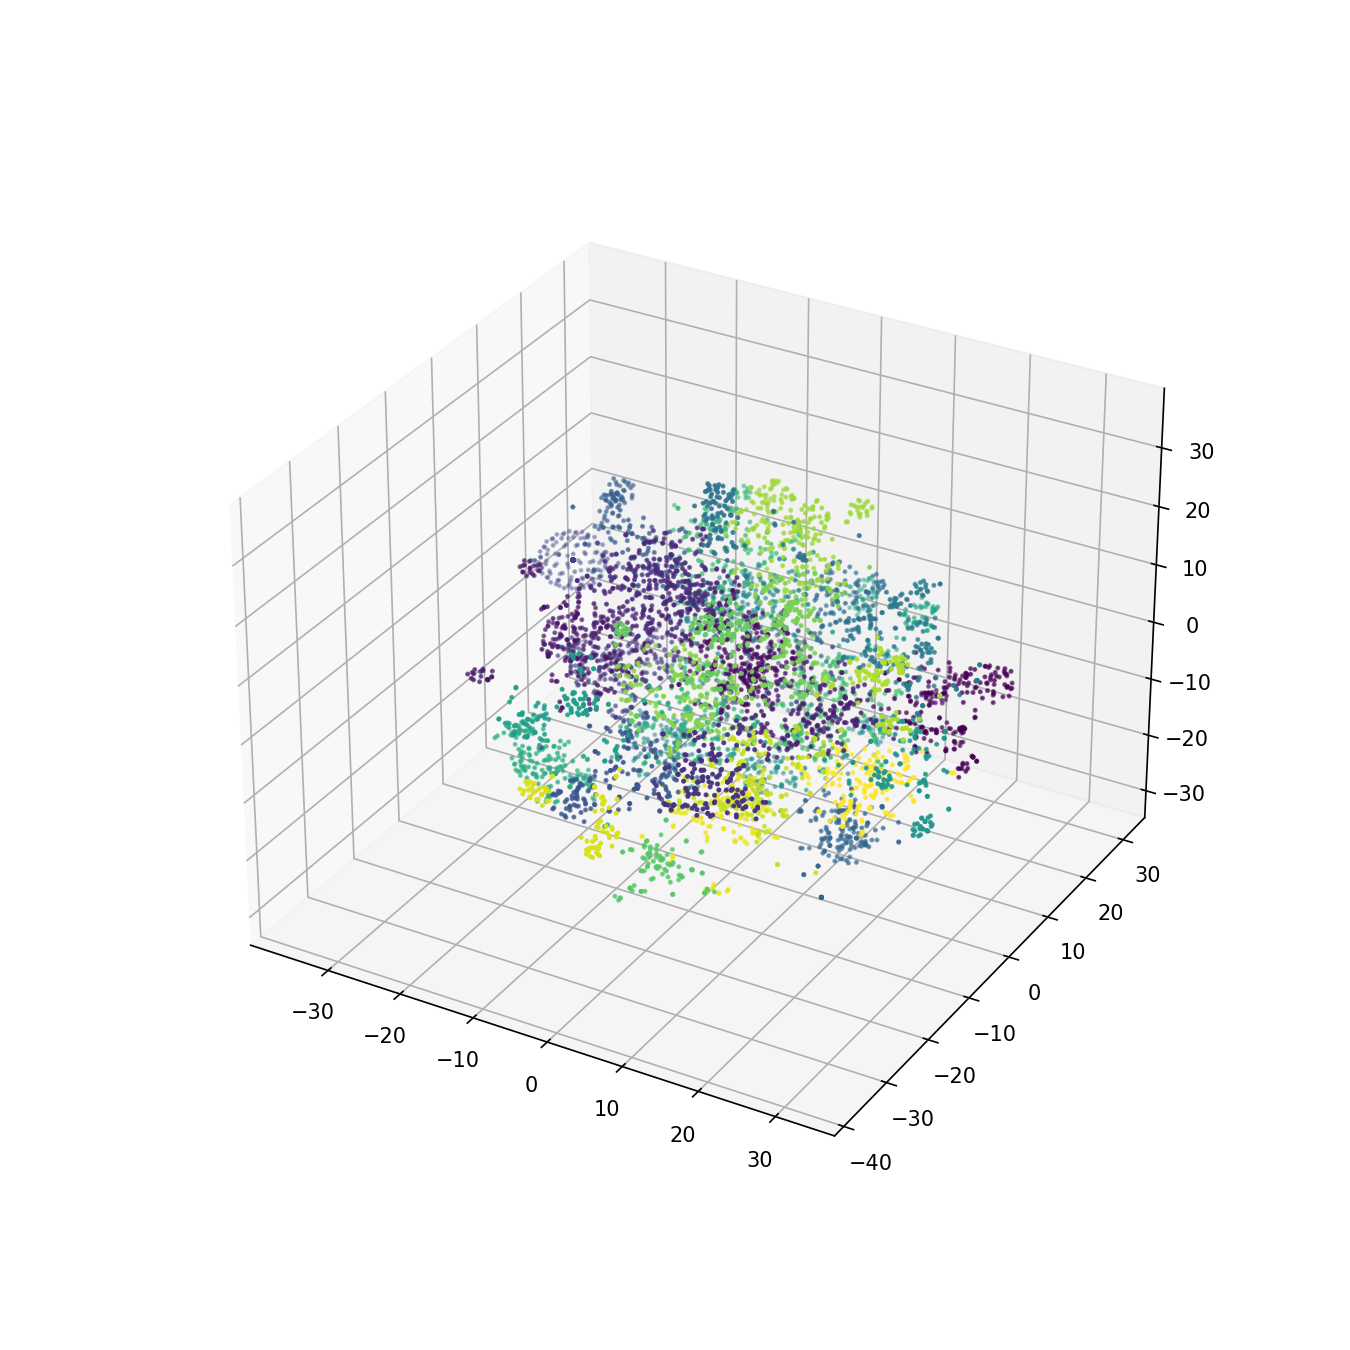

In [18]:
%matplotlib notebook

fig = plt.figure(figsize=(9, 9), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=clusters_3d, cmap='viridis', s=2)
fig.show()

In [19]:
def locate_3d(title):
    fig = plt.figure(figsize=(9, 9), dpi=100)
    ax = plt.axes(projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=clusters_3d, cmap='viridis', s=2)

    xmax, xmin = np.max(X_3d[:, 0]), np.min(X_3d[:, 0])
    ymax, ymin = np.max(X_3d[:, 1]), np.min(X_3d[:, 1])
    zmax, zmin = np.max(X_3d[:, 2]), np.min(X_3d[:, 2])
    
    idx = indices[title]
    coords = X_3d[idx]
    if isinstance(coords, np.ndarray) and len(coords) > 2:
        coords = coords[0]
    ax.scatter(coords[0], coords[1], coords[2], color='red', s=250)

    fig.show()

<IPython.core.display.Javascript object>


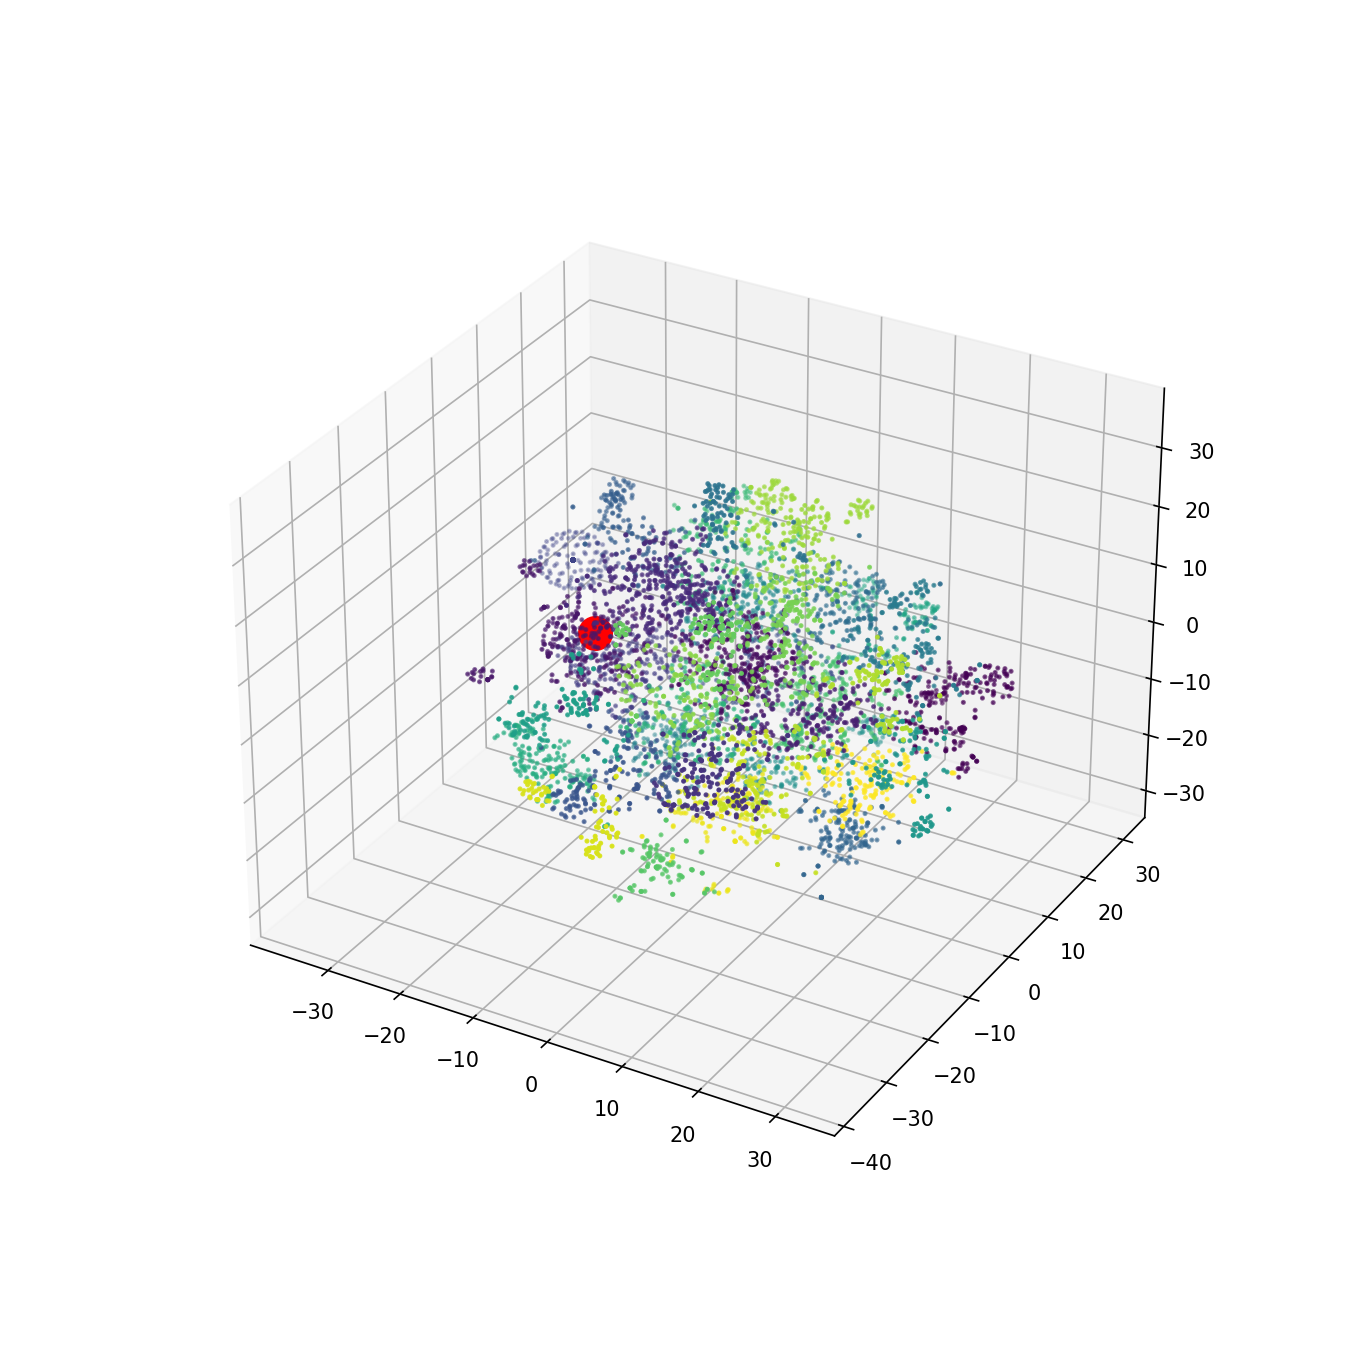

In [20]:
locate_3d('Emotional Intelligence')

## 6 - Zooming on Learning Object 
Region of the Learning Store can be crowded. Hence the use of this function to zoom in/out on the region. The zoom factor is passed as function parameter.

In [21]:
def locate_courses_with_zoom(title, zoom=1):
    figsrc, axsrc = plt.subplots()
    figzoom, axzoom = plt.subplots()
    axsrc.set(title='Original')
    axzoom.set(autoscale_on=False, title='Zoomed in')

    base = 100 * zoom
    zoom_x = abs(base - (np.max(X_reduced[:, 0])))
    zoom_y = abs(base - (np.max(X_reduced[:, 1])))
    zoom_avg = (zoom_x + zoom_y) / 2
    
    axsrc.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=5)
    axzoom.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=5+zoom_avg)

    idx = indices[title]
    coords = X_reduced[idx]
    if isinstance(coords, np.ndarray) and len(coords) > 2:
        coords = coords[0]

    center_x = coords[0]
    center_y = coords[1]
        
    axsrc.axvline(x=center_x, color='r', linestyle='-')
    axsrc.axhline(y=center_y, color='r', linestyle='-')
    
    axzoom.axvline(x=center_x, color='r', linestyle='-')
    axzoom.axhline(y=center_y, color='r', linestyle='-')
        
    axzoom.set_xlim(center_x - zoom_x, center_x + zoom_x)
    axzoom.set_ylim(center_y - zoom_y, center_y + zoom_y)
    figzoom.canvas.draw()

    plt.show()

<IPython.core.display.Javascript object>


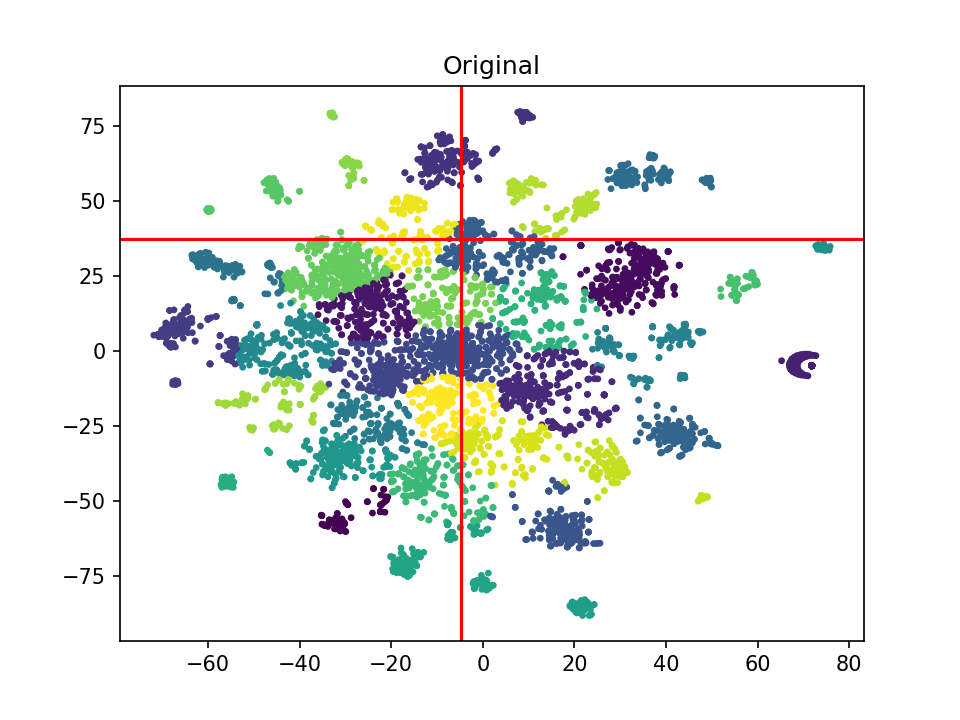

<IPython.core.display.Javascript object>


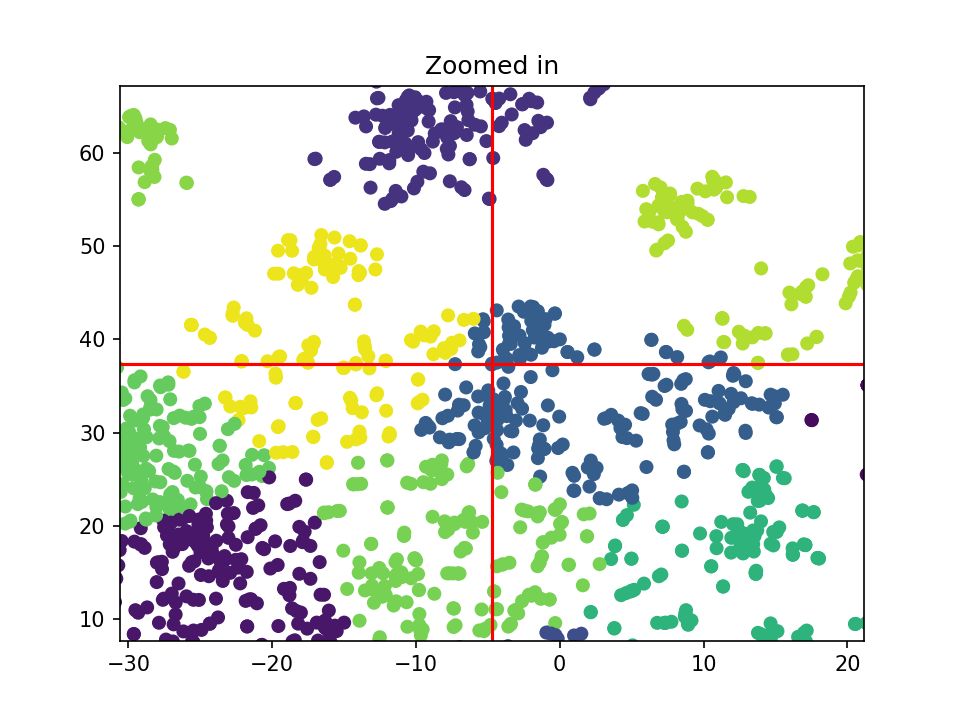

In [22]:
locate_courses_with_zoom('Emotional Intelligence', 0.5)